<a href="https://colab.research.google.com/github/HumaSatti/Depression-Detection-By-ML-Deep-Learning-Model/blob/main/Nurse_prediction_deep_leraning_model_small_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nurse-stress-prediction-wearable-sensors:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4110234%2F7125235%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240726%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240726T160340Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5a9f0aeec430ad7e899cbb618384230876f4fc1b769adcef5b20859174edd0f7e2302599c59322b863fe2071202178a91c5eaa37556c50713ae7c9aaf7aca4094d6b4186a8571625a404340b7eb9c4209b1c8c2719654504db446fef211e1230a145859d3c932b986ec948856e008ed0bf46495c7ee9588fc9dfc88e0a967617bf11c623ead61de6f3c479ef7f7116ed7884bd546ec4cd13646cad9bda216f7ade1739d123e654e3c998fa754f6366fe1e53df577d8c378dcee0a122bbebc3f6cecca203539d08a3db292d962ab8e1fa47b5326c117357625fdadc705836b41399f52150f82a9b19ed488ae0bf97ebd855c868b754bee69d788ba394564593ba'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 79877492 bytes downloaded
Downloaded and uncompressed: nurse-stress-prediction-wearable-sensors
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import  accuracy_score, precision_recall_fscore_support

In [7]:
# Load the dataset
df = pd.read_csv('/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv', low_memory=False, parse_dates=['datetime'])
df

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509051 entries, 0 to 11509050
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   X         float64       
 1   Y         float64       
 2   Z         float64       
 3   EDA       float64       
 4   HR        float64       
 5   TEMP      float64       
 6   id        object        
 7   datetime  datetime64[ns]
 8   label     float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 790.3+ MB


In [9]:
df.head(8)

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
5,-9.0,-57.0,-32.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.156250112,2.0
6,9.0,-68.0,-2.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.187500032,2.0
7,-6.0,-74.0,17.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.218749952,2.0


In [10]:
df.datetime

0          2020-07-08 14:03:00.000000000
1          2020-07-08 14:03:00.031249920
2          2020-07-08 14:03:00.062500096
3          2020-07-08 14:03:00.093750016
4          2020-07-08 14:03:00.124999936
                        ...             
11509046   2020-07-23 17:28:59.875000064
11509047   2020-07-23 17:28:59.906249984
11509048   2020-07-23 17:28:59.937499904
11509049   2020-07-23 17:28:59.968750080
11509050   2020-07-23 17:29:00.000000000
Name: datetime, Length: 11509051, dtype: datetime64[ns]

In [11]:
#df.isna().sum()
print(df.isna().sum())

X           0
Y           0
Z           0
EDA         0
HR          0
TEMP        0
id          0
datetime    0
label       0
dtype: int64


In [12]:
df.nunique()

X                256
Y                256
Z                256
EDA           274452
HR              6268
TEMP             599
id                15
datetime    10628304
label              3
dtype: int64

In [13]:
num_duplicated_rows = df.duplicated().sum()
num_duplicated_rows
print(f'Number of duplicated rows: {num_duplicated_rows}')

Number of duplicated rows: 105606


In [14]:

# Remove duplicates and handle missing values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [15]:
# Extract datetime features
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

In [16]:
# Drop unnecessary columns
df.drop(['datetime', 'id'], axis=1, inplace=True)

Exploratory Data Analysis

<ipython-input-17-a2b9352c5d7f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['X'])


<Axes: xlabel='X', ylabel='Density'>

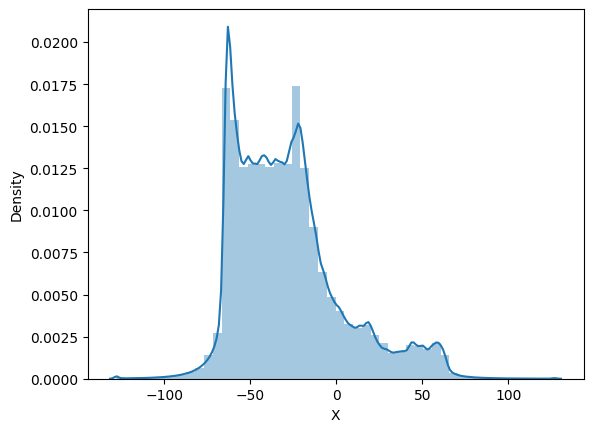

In [17]:
sns.distplot(df['X'])

<ipython-input-18-872cac5ad94b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Y'])


<Axes: xlabel='Y', ylabel='Density'>

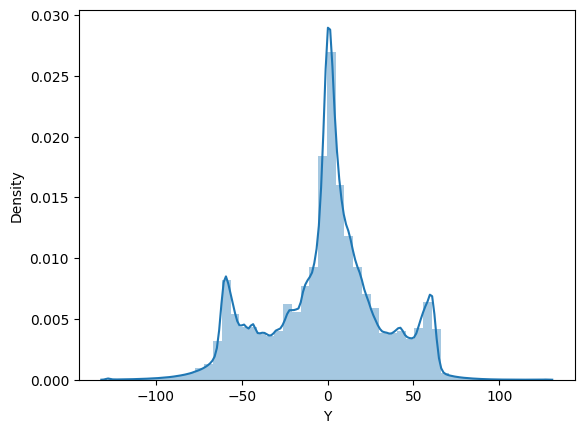

In [18]:
sns.distplot(df['Y'])

<ipython-input-19-35d55cf5293c>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['EDA'])


<Axes: xlabel='EDA', ylabel='Density'>

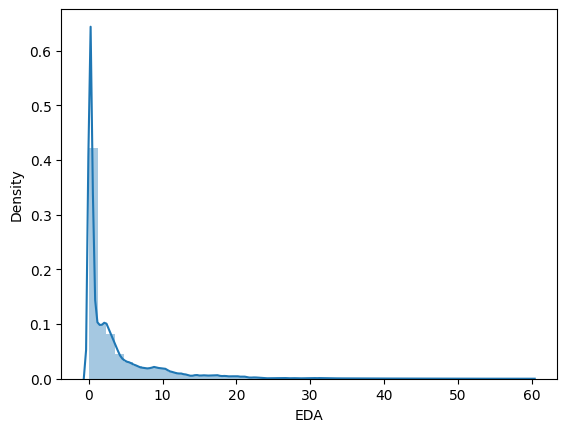

In [19]:
sns.distplot(df['EDA'])

<ipython-input-20-7a31c5f1f151>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['HR'])


<Axes: xlabel='HR', ylabel='Density'>

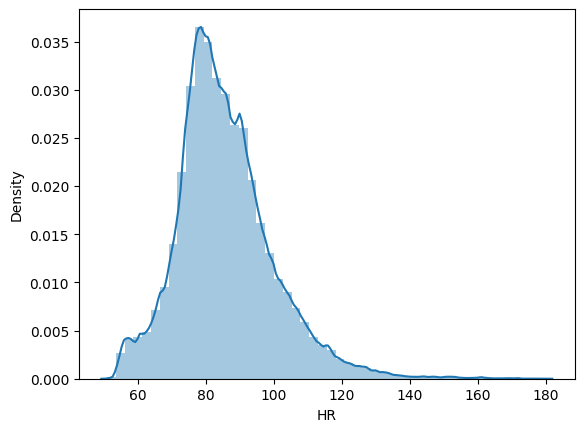

In [20]:
sns.distplot(df['HR'])

<ipython-input-21-adc904bfd6a8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['TEMP'])


<Axes: xlabel='TEMP', ylabel='Density'>

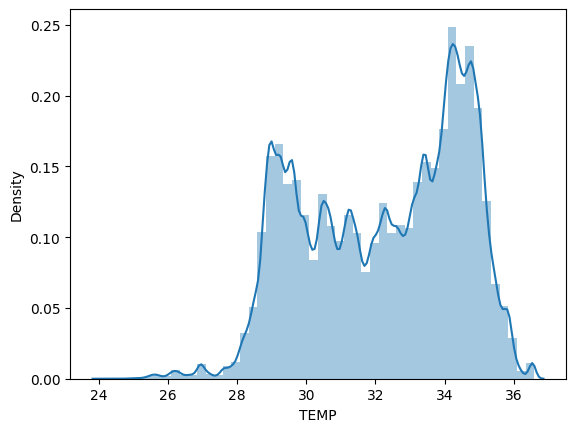

In [21]:
sns.distplot(df['TEMP'])

In [22]:
df['label'].value_counts()

label
2.0    8467619
0.0    2162245
1.0     773581
Name: count, dtype: int64

Text(0, 0.5, 'Frequency')

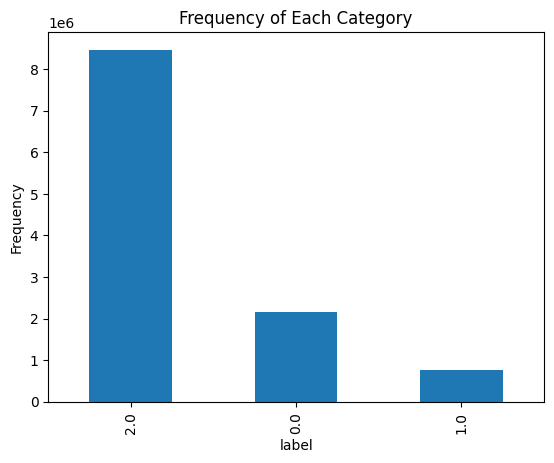

In [23]:
df['label'].value_counts().plot(kind='bar')
plt.title('Frequency of Each Category')
plt.ylabel('Frequency')

In [24]:
# Correlation matrix
corr_mat = df.corr().round(2)
# Correlation matrix
corr_mat

,X,Y,Z,EDA,HR,TEMP,label,month,day,hour,minute,second
X,1.00,0.06,0.20,0.10,0.13,0.03,-0.01,0.12,-0.15,0.10,-0.01,0.0
Y,0.06,1.00,0.02,-0.09,-0.07,-0.08,-0.02,-0.07,0.05,0.15,-0.04,-0.0
Z,0.20,0.02,1.00,0.01,-0.10,-0.03,-0.06,-0.05,-0.03,0.07,0.02,0.0
EDA,0.10,-0.09,0.01,1.00,0.14,0.35,0.05,-0.10,0.02,-0.10,0.03,-0.0
HR,0.13,-0.07,-0.10,0.14,1.00,0.16,-0.03,0.03,0.08,-0.06,-0.01,-0.0
TEMP,0.03,-0.08,-0.03,0.35,0.16,1.00,0.14,0.18,-0.11,-0.25,-0.00,-0.0
label,-0.01,-0.02,-0.06,0.05,-0.03,0.14,1.00,0.15,-0.08,-0.26,-0.02,-0.0
month,0.12,-0.07,-0.05,-0.10,0.03,0.18,0.15,1.00,-0.45,-0.60,-0.01,-0.0
day,-0.15,0.05,-0.03,0.02,0.08,-0.11,-0.08,-0.45,1.00,0.16,0.03,0.0
hour,0.10,0.15,0.07,-0.10,-0.06,-0.25,-0.26,-0.60,0.16,1.00,-0.05,0.0


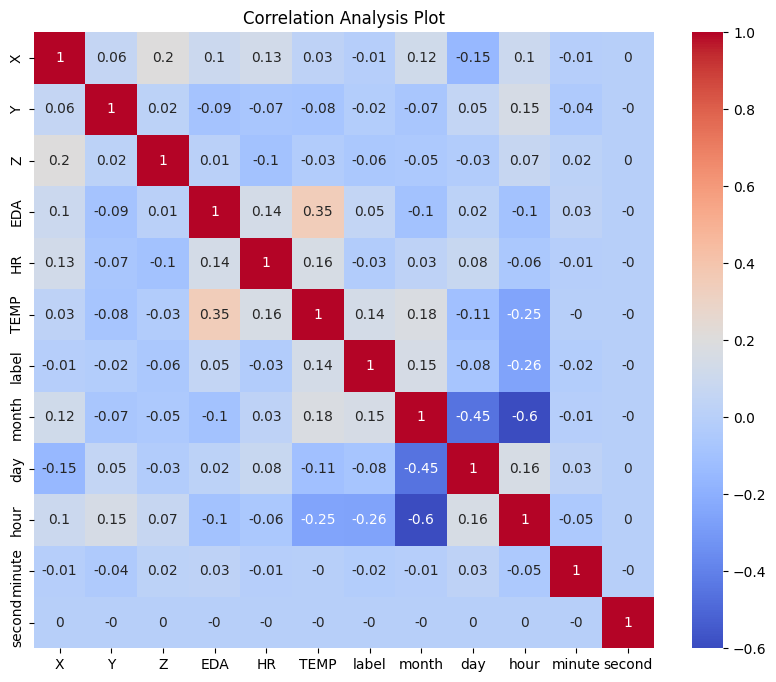

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis Plot')
plt.show()

In [26]:
corr_mat['label']

X        -0.01
Y        -0.02
Z        -0.06
EDA       0.05
HR       -0.03
TEMP      0.14
label     1.00
month     0.15
day      -0.08
hour     -0.26
minute   -0.02
second   -0.00
Name: label, dtype: float64

In [31]:
# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

In [32]:
# Sample a subset of the data for initial training (e.g., 1% of the data)
sample_frac = 0.01
X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=1-sample_frac, stratify=y, random_state=42)


In [33]:
# Handle imbalanced data
over_sample = RandomOverSampler(random_state=42)
X_sampled, y_sampled = over_sample.fit_resample(X_sampled, y_sampled)


In [34]:
# Split the sampled dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [35]:
# Scale the features
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [36]:
# Set up the strategy for TPU/CPU/GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU and GPU


In [37]:
# Build the model inside the strategy scope
with strategy.scope():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')  # Adjust the output layer according to your number of classes
    ])


In [38]:
 model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [39]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')


In [40]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint])


Epoch 1/50
6351/6351 [==============================] - 29s 4ms/step - loss: 0.5089 - accuracy: 0.7729 - val_loss: 0.2491 - val_accuracy: 0.9122
Epoch 2/50
6351/6351 [==============================] - 25s 4ms/step - loss: 0.3012 - accuracy: 0.8793 - val_loss: 0.1706 - val_accuracy: 0.9409
Epoch 3/50
6351/6351 [==============================] - 24s 4ms/step - loss: 0.2531 - accuracy: 0.9010 - val_loss: 0.1383 - val_accuracy: 0.9453
Epoch 4/50
6351/6351 [==============================] - 25s 4ms/step - loss: 0.2266 - accuracy: 0.9125 - val_loss: 0.1212 - val_accuracy: 0.9524
Epoch 5/50
6351/6351 [==============================] - 24s 4ms/step - loss: 0.2112 - accuracy: 0.9185 - val_loss: 0.1009 - val_accuracy: 0.9647
Epoch 6/50
6351/6351 [==============================] - 23s 4ms/step - loss: 0.1993 - accuracy: 0.9233 - val_loss: 0.0873 - val_accuracy: 0.9702
Epoch 7/50
6351/6351 [==============================] - 25s 4ms/step - loss: 0.1910 - accuracy: 0.9271 - val_loss: 0.0876 - val_ac

In [41]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


794/794 [==============================] - 2s 2ms/step - loss: 0.0417 - accuracy: 0.9885
Test Loss: 0.0417485386133194, Test Accuracy: 0.9885053038597107


In [42]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


794/794 [==============================] - 2s 2ms/step


In [43]:
y_pred

array([[2.2409825e-02, 6.7456728e-01, 3.0302286e-01],
       [9.9985266e-01, 1.0404333e-09, 1.4726962e-04],
       [1.9879153e-05, 1.4763883e-21, 9.9998009e-01],
       ...,
       [3.7523146e-06, 5.7648191e-05, 9.9993861e-01],
       [2.1676358e-02, 4.1170367e-03, 9.7420663e-01],
       [2.9018074e-06, 3.4640891e-07, 9.9999678e-01]], dtype=float32)

In [44]:
y_pred_classes

array([1, 0, 2, ..., 2, 2, 2])

In [45]:
# Classification report
print(classification_report(y_test, y_pred_classes))


              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      8522
         1.0       0.99      1.00      1.00      8391
         2.0       0.99      0.98      0.98      8490

    accuracy                           0.99     25403
   macro avg       0.99      0.99      0.99     25403
weighted avg       0.99      0.99      0.99     25403



In [46]:
# Precision, Recall, F1-Score, and Support
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f'\nPrecision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.9885
Recall: 0.9885
F1 Score: 0.9885


In [47]:
print('Classification Report:')
print(classification_report)

Classification Report:
<function classification_report at 0x7e51816c9630>


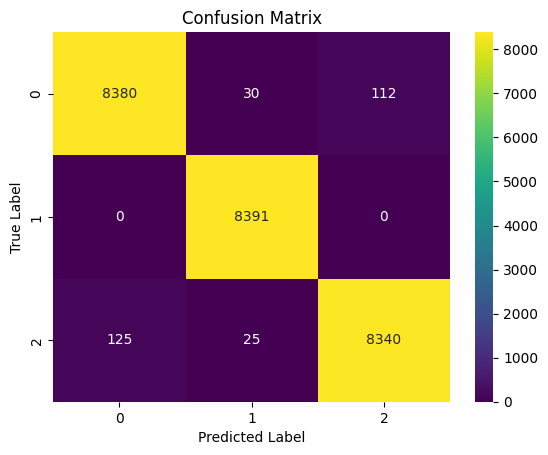

In [48]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [49]:
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[8380   30  112]
 [   0 8391    0]
 [ 125   25 8340]]


In [50]:
print("Deep Learning Model Performance:")
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

Deep Learning Model Performance:
[[8380   30  112]
 [   0 8391    0]
 [ 125   25 8340]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      8522
         1.0       0.99      1.00      1.00      8391
         2.0       0.99      0.98      0.98      8490

    accuracy                           0.99     25403
   macro avg       0.99      0.99      0.99     25403
weighted avg       0.99      0.99      0.99     25403



In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 11971 (46.76 KB)
Trainable params: 11971 (

In [52]:
model.get_weights()

[array([[ 2.00505182e-03,  2.61910185e-02,  6.08187914e-03, ...,
         -1.50347920e-02,  3.53709199e-02, -5.19541800e-02],
        [-2.01240350e-02, -4.11128290e-02,  1.07889157e-02, ...,
         -3.02389488e-02,  6.07130118e-03, -8.50549806e-03],
        [-5.43461181e-02,  4.60652113e-02,  1.19291036e-03, ...,
          3.72922719e-02,  1.08240426e-01, -1.01420283e-02],
        ...,
        [ 3.92653465e-01,  1.20579684e+00,  7.35819042e-02, ...,
         -1.54557478e+00,  1.07151794e+00, -1.35038626e+00],
        [ 1.03744507e-01,  1.85470656e-01,  1.31133320e-02, ...,
         -1.19057801e-02,  1.71379119e-01, -2.69004852e-02],
        [ 3.97334844e-02, -1.99296069e-03, -2.72353936e-04, ...,
         -1.15712862e-02, -3.18652131e-02,  2.29286402e-03]], dtype=float32),
 array([-0.7084143 , -0.7161826 , -0.53944254, -1.3742696 , -0.6710106 ,
        -0.8132222 , -0.0429143 , -0.9076486 , -1.2130334 , -0.11923008,
        -0.06844198, -1.5352317 , -0.8688286 , -0.6354869 , -0.57756

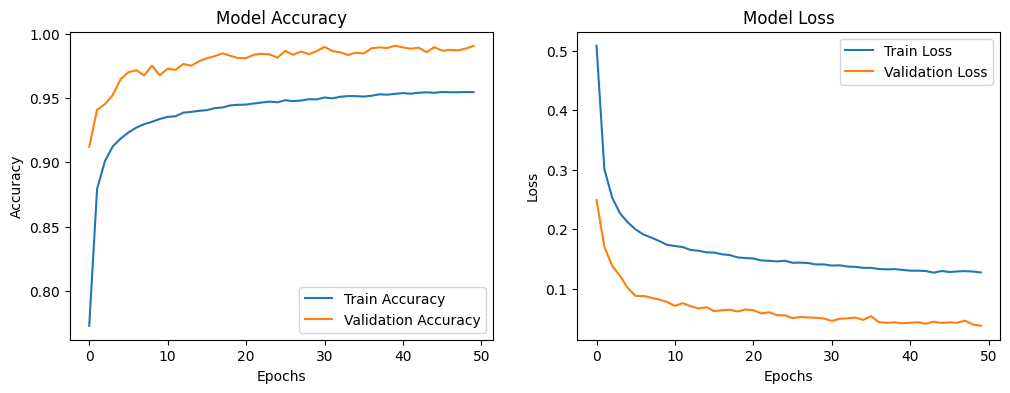

In [53]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch	Train Accuracy	Validation Accuracy
1	0.7729		0.9122
2	0.8793		0.9409
3	0.9010		0.9453
4	0.9125		0.9524
5	0.9185		0.9647
6	0.9233		0.9702
7	0.9271		0.9717
8	0.9297		0.9676
9	0.9316		0.9753
10	0.9338		0.9678
11	0.9354		0.9729
12	0.9359		0.9720
13	0.9387		0.9766
14	0.9393		0.9752
15	0.9401		0.9787
16	0.9406		0.9810
17	0.9422		0.9826
18	0.9427		0.9848
19	0.9444		0.9829
20	0.9448		0.9811
21	0.9450		0.9811
22	0.9458		0.9838
23	0.9465		0.9845
24	0.9473		0.9840
25	0.9468		0.9815
26	0.9483		0.9868
27	0.9476		0.9837
28	0.9481		0.9863
29	0.9491		0.9842
30	0.9490		0.9866
31	0.9505		0.9898
32	0.9498		0.9866
33	0.9510		0.9856
34	0.9516		0.9835
35	0.9515		0.9853
36	0.9512		0.9847
37	0.9518		0.9887
38	0.9529		0.9895
39	0.9527		0.9890
40	0.9533		0.9907
41	0.9539		0.9895
42	0.9534		0.9884
43	0.9542		0.9892
44	0.9545		0.9857
45	0.9541		0.9896
46	0.9548		0.9869
47	0.9546		0.9875
48	0.9546		0.9871
49	0.9547		0.9885
50	0.9546		0.9906


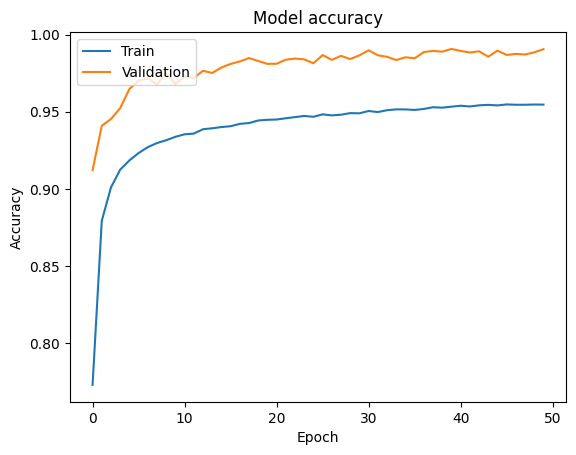

In [54]:
# Extract training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy values
print("Epoch\tTrain Accuracy\tValidation Accuracy")
for epoch in range(len(train_accuracy)):
    print(f"{epoch+1}\t{train_accuracy[epoch]:.4f}\t\t{val_accuracy[epoch]:.4f}")

# Optional: Visualize the training history
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [55]:
model.save('final_model.keras')

In [56]:
import json

history_dict = history.history
with open('history.json', 'w') as f:
    json.dump(history_dict, f)